In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [4]:
import pandas as pd

In [5]:
import datetime as dt

# General Overview of Datasets
## Familiarize with the data

In [6]:
measurement_df = pd.read_csv("Resources/hawaii_measurements.csv")
station_df = pd.read_csv("Resources/hawaii_stations.csv")

In [7]:
measurement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  19550 non-null  object 
 1   date     19550 non-null  object 
 2   prcp     18103 non-null  float64
 3   tobs     19550 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 611.1+ KB


In [7]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    9 non-null      object 
 1   name       9 non-null      object 
 2   latitude   9 non-null      float64
 3   longitude  9 non-null      float64
 4   elevation  9 non-null      float64
dtypes: float64(3), object(2)
memory usage: 488.0+ bytes


# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [9]:
#Creating a database engine
#dialact object = hawaii.sqlite 
#no pool created here, but is possible
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [10]:
# reflect an existing database into a new model - brings the ORM
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
m = Base.classes.measurement
s = Base.classes.station

# station = pd.read_sql("SELECT * FROM station", conn)
# measurement = pd.read_sql("SELECT * FROM measurement", conn)

In [13]:
# Create our session (link) from Python to the ORM which is linked to the base linked to connection and engine 
session = Session(engine)

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Get the last date in the dataset
last_date = session.query(m.date).order_by(m.date.desc()).first()[0]

#Convert query result (string) to datetime
last_date = dt.datetime.strptime(str(last_date), "%Y-%M-%d")

# Calculate the date 1 year ago from the last data point in the database
one_year = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(m.date, m.station, m.prcp, m.tobs).filter(m.date > one_year)

one_df = pd.DataFrame(query)

,date,station,prcp,tobs
0,2016-01-25,USC00519397,0.04,71.0
1,2016-01-26,USC00519397,0.16,68.0
2,2016-01-27,USC00519397,0.01,68.0
3,2016-01-28,USC00519397,0.00,65.0
4,2016-01-29,USC00519397,0.00,67.0
...,...,...,...,...
3560,2017-08-19,USC00516128,0.09,71.0
3561,2017-08-20,USC00516128,NaN,78.0
3562,2017-08-21,USC00516128,0.56,76.0
3563,2017-08-22,USC00516128,0.50,76.0


## Precipitation Analysis

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
one_df["prcp"].describe()

count    3201.000000
mean        0.179641
std         0.495144
min         0.000000
25%         0.000000
50%         0.020000
75%         0.140000
max         9.640000
Name: prcp, dtype: float64

In [17]:
#Query for the last year of precipitation data
prcp_query = session.query(m.date, m.prcp)\
                    .filter(m.date > one_year)

#Convert to pandas dataframe set date to index
prcp_year = pd.DataFrame(prcp_query).set_index(['date']).sort_values("date")

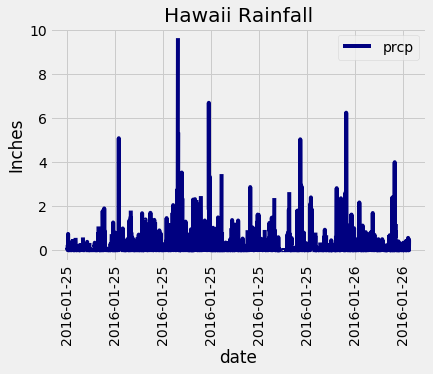

In [18]:
ax = prcp_year.plot(y = 'prcp', title="Hawaii Rainfall", use_index=True, color = "navy")
ax.set_ylabel("Inches")
ax.set_xticklabels(prcp_year.index,rotation = 90)

plt.savefig("hawaii_rainfall.png")
plt.show()

## Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset? 
#Pandas version
tot_stat = one_df["station"].nunique()
print(f"There are {tot_stat} stations in the dataset.")

There are 7 stations in the dataset.


In [20]:
# Design a query to show how many stations are available in this dataset? 
#SQLAlchmey version
x = session.query(distinct(m.station))\
            .filter(m.date > one_year)\
            .count()
print(f"There are {x} weather stations in the Hawaii dataset.")


There are 7 weather stations in the Hawaii dataset.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stat_top = one_df.groupby(["station"])\
                    .count()["tobs"]\
                    .sort_values(ascending=False)
stat_top = pd.DataFrame(stat_top).reset_index()
top_station = stat_top.iloc[0]["station"]
top_counts = stat_top.iloc[0]["tobs"]

print(f"The most active weather station is {top_station} with {top_counts} recordings")

The most active weather station is USC00519397 with 572 recordings


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_top_temp = session.query(m.tobs)\
            .filter(m.date > one_year)\
            .filter(m.station == top_station)\
            .order_by(m.tobs).first()

high_top_temp = session.query(m.tobs)\
            .filter(m.date > one_year)\
            .filter(m.station == top_station)\
            .order_by(m.tobs.desc()).first()

avg_top_temp = session.query(func.avg(m.tobs))\
            .filter(m.date > one_year)\
            .filter(m.station == top_station).first()

#Convert results to dataframe
low_top_temp = pd.DataFrame(low_top_temp).reset_index()
low_top_temp = low_top_temp.iloc[0][0]

#Convert results to dataframe
high_top_temp = pd.DataFrame(high_top_temp).reset_index()
high_top_temp = high_top_temp.iloc[0][0]

#Convert results to dataframe
avg_top_temp = pd.DataFrame(avg_top_temp).reset_index()
avg_top_temp = avg_top_temp.iloc[0][0]



In [23]:

print(f"Temperature recordings for weather station {top_station}")
print("------------------------------------------------------")
print(f"Minumum Temperature: {low_top_temp}")
print(f"Maximum Temperture: {high_top_temp}")
print(f"Average Temperature: {round(avg_top_temp,1)}")

Temperature recordings for weather station USC00519397
------------------------------------------------------
Minumum Temperature: 60.0
Maximum Temperture: 87.0
Average Temperature: 75.0


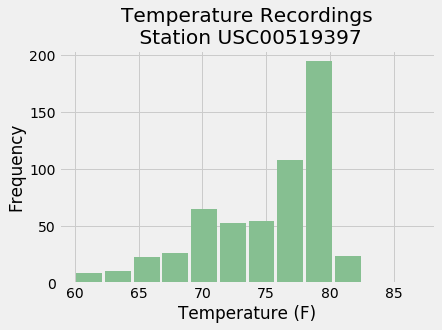

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_top_temp = session.query(m.date, m.tobs)\
            .filter(m.date > one_year)\
            .filter(m.station == top_station)
year_top_temp = pd.DataFrame(year_top_temp)

year_top_temp_hist = plt.hist(year_top_temp["tobs"], bins = 12,
                      facecolor='#86bf91', zorder=2, rwidth=0.9)

plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Recordings\n Station {top_station}")
plt.grid(True)
plt.savefig("top_station_temp.png")
plt.show()

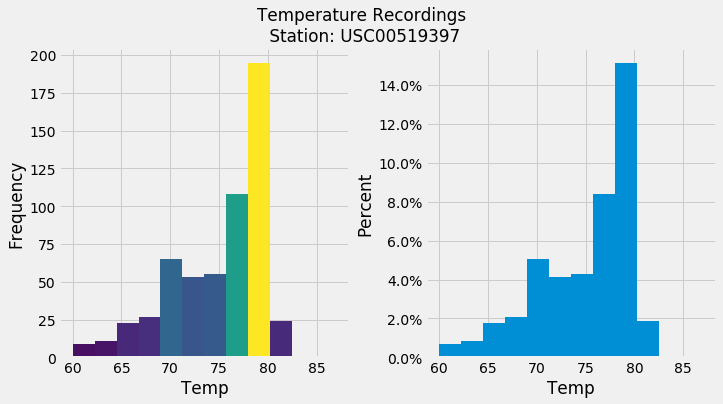

In [69]:
#playing around with Matplotlib for cool histograms
x = year_top_temp["tobs"]
plt.close('all')
fig, (ax1, ax2)= plt.subplots(1, 2, figsize = (10,5))

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = ax1.hist(x, bins=12)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
ax2.hist(x, bins=12, density=True)

# Now we format the y-axis to display percentage
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))

suptitle = plt.suptitle(f"Temperature Recordings\n Station: {top_station}", y=1.1)
ax1.set_ylabel("Frequency")
ax2.set_ylabel("Percent")
ax1.set_xlabel("Temp")
ax2.set_xlabel("Temp")

plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 1)
plt.savefig("top_station_temp_heat.png", bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()


## Bonus Challenge Assignment

In [77]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(m.tobs), func.avg(m.tobs), func.max(m.tobs)).\
        filter(m.date >= start_date).filter(m.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(66.0, 72.95081967213115, 80.0)]


In [79]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(m.tobs), func.avg(m.tobs), func.max(m.tobs)).\
        filter(m.date >= start_date).filter(m.date <= end_date).all()
print(calc_temps("2014-11-22","2014-11-30"))

[(66.0, 72.95081967213115, 80.0)]


In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
